# Capstone Project - Smart Basket for Automatic Product Classification and Counting


___




**Problem Statement:**

In supermarkets and grocery stores, the process of identifying and counting products often requires manual input, which can be slow and prone to errors. This inefficiency can lead to longer checkout times and inaccurate pricing, which negatively impacts both customer experience and store operations. Developing a "smart basket" that automatically recognizes products based on images can significantly speed up the shopping process.

**Context:**

As the retail industry increasingly moves towards automation and efficiency, there is a growing need for smart solutions that can streamline the shopping experience. A smart basket that uses image processing to identify and count products can reduce the need for manual scanning and entry, making the checkout process faster and more accurate. This project aims to bridge this gap by leveraging image processing techniques to develop a model capable of classifying and counting products in real-time.

**Data Sources:**

Primary Dataset: Fruits-360 dataset https://www.kaggle.com/moltean/fruits containing over 70,000 images of 120 types of fruits and vegetables. This dataset will be used to train and validate the image classification model.



## 1 Data Loading

Download the necessary libraries for working with archives, file system and data analysis

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [113]:
%matplotlib inline

In [114]:
import pickle

# Loading a global variable from a file
with open('df_train.pkl', 'rb') as f:
    my_global_df_train = pickle.load(f)

# Проверка содержимого
my_global_df_train.head()


,label,image_path,brightness,image_size,processed_image
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,112.487951,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,108.764763,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,146.202051,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 4, 38, 25..."
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,134.131658,"(100, 100)","[[255, 255, 79, 0, 0, 167, 255, 255, 255, 255,..."
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,96.214535,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [115]:
# Loading a global variable from a file
with open('df_train.pkl', 'rb') as f:
    my_global_df_test = pickle.load(f)

# Проверка содержимого
my_global_df_test.head()

,label,image_path,brightness,image_size,processed_image
0,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,112.487951,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,108.764763,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,146.202051,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 4, 38, 25..."
3,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,134.131658,"(100, 100)","[[255, 255, 79, 0, 0, 167, 255, 255, 255, 255,..."
4,cucumber_3,../data/raw/fruits-360/fruits-360/fruits-360-o...,96.214535,"(100, 100)","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [116]:
df_train = my_global_df_train
df_test = my_global_df_test

In [117]:
# Step 1: Extracting image and label data
X_train = np.stack(df_train['processed_image'].values)
y_train = df_train['label'].values
X_test = np.stack(df_test['processed_image'].values)
y_test = df_test['label'].values

In [118]:
# Checking the data form
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3110, 100, 100)
y_train: (3110,)
X_test: (3110, 100, 100)
y_test: (3110,)


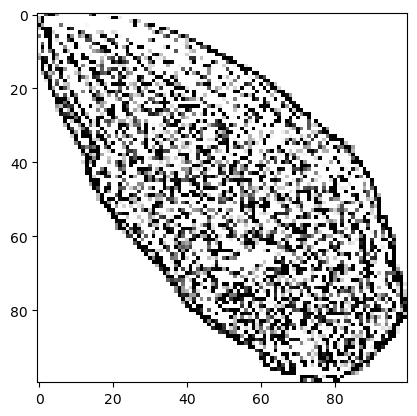

In [121]:
plt. imshow(X_train[3],cmap='gray')